#### Задача: спрогнозировать потребление электроэнергии с 2019-09-09 по 2019-09-22
При оценке использовать RMSE.

In [3]:
import copy

#mathematical operations
import numpy as np

#data handling
import pandas as pd

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#dealing with time
import datetime

#machine learning and statistical methods
import statsmodels.api as sm

#selected preprocessing and evaluation methods
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#regression models
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor;

In [51]:
#reading dataset
df = pd.read_csv('data_train.csv')

In [52]:
df.head()

,timestamp,fact
0,2019-01-01 00:00:00,294.0
1,2019-01-01 01:00:00,292.0
2,2019-01-01 02:00:00,290.0
3,2019-01-01 03:00:00,293.0
4,2019-01-01 04:00:00,294.0


In [53]:
#main info and check for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6024 entries, 0 to 6023
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  6024 non-null   object 
 1   fact       6024 non-null   float64
dtypes: float64(1), object(1)
memory usage: 94.2+ KB


In [54]:
# convert timestamp to datetime and making it as index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df.sort_index(inplace=True)

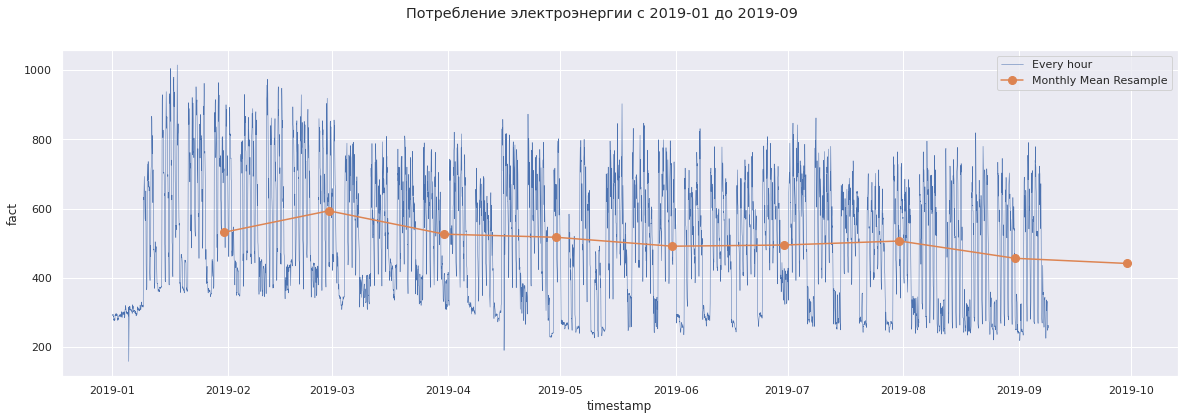

In [55]:
#plot the data and visualize monthly mean value
y = df['fact']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,linestyle='-', linewidth=0.5, label='Every hour')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('fact')
ax.set_xlabel('timestamp')
plt.suptitle('Потребление электроэнергии с 2019-01 до 2019-09')
ax.legend();

In [56]:
df = df.loc['2019-01-10':]
y = df['fact']

In [57]:
#!pip install statsmodels --upgrade

In [58]:
#extracting daily seasonality
sd_24 = sm.tsa.seasonal_decompose(y, model='additive', period=24)

#extracting weekly seasonality
sd_168 = sm.tsa.seasonal_decompose(y - np.array(sd_24.seasonal), period=168)

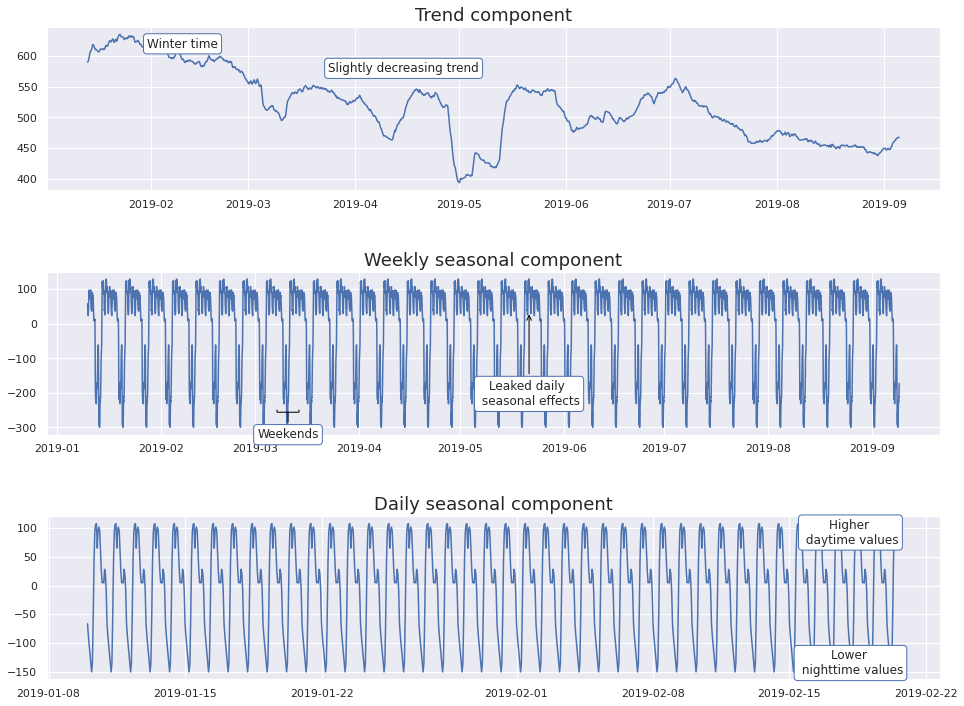

In [59]:
#drawing figure with subplots
f, axes = plt.subplots(3, 1, figsize=(16,12));

#plotting trend component
axes[0].plot(sd_168.trend)
axes[0].set_title('Trend component', fontdict={'fontsize': 18});   
axes[0].text(datetime.datetime(2019,2, 10), 620, 'Winter time',
             ha='center', va='center', bbox=dict(fc='white', ec='b', boxstyle='round'));
axes[0].text(datetime.datetime(2019, 4, 15), 580, 'Slightly decreasing trend',
             ha='center', va='center', bbox=dict(fc='white', ec='b', boxstyle='round'));    

#plotting week seasonal component
axes[1].plot(sd_168.seasonal);
axes[1].set_title('Weekly seasonal component', fontdict={'fontsize': 18});
axes[1].annotate('Leaked daily \n seasonal effects', xy=(0.54, 0.75),
            xycoords='axes fraction',
            va='center', ha='center',
            xytext=(0.54, 0.25),
            textcoords='axes fraction',
            bbox=dict(boxstyle='round', fc='w', ec='b'),
            arrowprops=dict(color='black',
                            arrowstyle='->',
                            connectionstyle='arc3'));
axes[1].annotate('Weekends', xy=(0.27, 0.15),
            xycoords='axes fraction',
            va='center', ha='center',
            xytext=(0.27, 0),
            textcoords='axes fraction',
            bbox=dict(boxstyle='round', fc='w', ec='b'),
            arrowprops=dict(color='black',
                            arrowstyle='-[',
                            mutation_scale=11,
                            connectionstyle='arc3'));         

#plotting day seasonal component
axes[2].plot(sd_24.seasonal[:1000])
axes[2].set_title('Daily seasonal component', fontdict={'fontsize': 18});
axes[2].annotate('Higher \n daytime values', xy=(0.54, 0.50),
            xycoords='axes fraction',
            va='center', ha='center',
            xytext=(0.9, 0.9),
            textcoords='axes fraction',
            bbox=dict(boxstyle='round', fc='w', ec='b'));
axes[2].annotate('Lower \n nighttime values', xy=(0.54, 0.50),
            xycoords='axes fraction',
            va='center', ha='center',
            xytext=(0.9, 0.1),
            textcoords='axes fraction',
            bbox=dict(boxstyle='round', fc='w', ec='b'));   

plt.subplots_adjust(hspace=0.5)
plt.show();

Попробуем что-нибудь предсказать. Перед этим добавим к нашему датасету хвост с датами, которые нужно спрогнозировать.

In [60]:
#create an array for dates between '2019-09-09' and '2019-09-22'
rng = pd.date_range('2019-09-09', periods=24*14, freq='H')
df_forecast = pd.DataFrame({ 'timestamp': rng , 'fact': 0})
df_forecast['timestamp'] = pd.to_datetime(df_forecast['timestamp'])
df_forecast = df_forecast.set_index('timestamp')

In [61]:
#concatenate main dataset and tail, that we need to predict
df_concat = pd.concat([df.loc['2019-01-10':], df_forecast])
df_concat.tail()

,fact
timestamp,
2019-09-22 19:00:00,0.0
2019-09-22 20:00:00,0.0
2019-09-22 21:00:00,0.0
2019-09-22 22:00:00,0.0
2019-09-22 23:00:00,0.0


In [62]:
def preprocess_data(df):
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month

    #create lag variable by shifting the target value
    df['fact_prev_2_week_same_hour'] = df['fact'].shift(24*7*2)
    df['fact_prev_2_week_1_hour_ago'] = df['fact'].shift(24*7*2 + 1)
    df['fact_prev_2_week_2_hours_ago'] = df['fact'].shift(24*7*2 + 2)
    df['fact_prev_3_week_same_hour'] = df['fact'].shift(24*7*3)
    

    #drop NaNs after feature engineering
    df.dropna(how='any', axis=0, inplace=True)
    return df

def split_data(df, horizon=24*7*2):    
    X = df.drop('fact', axis=1)
    y = df['fact']

    #4 weeks of the dataset for validation
    X_train, X_valid = X.iloc[:- horizon * 3,:], X.iloc[-horizon * 3: - horizon,:] 
    y_train, y_valid = y.iloc[:- horizon * 3], y.iloc[- horizon * 3: - horizon]

    #last 2 weeks for predicting
    X_test = X.iloc[- horizon:,:]

    return X_train, X_valid, y_train, y_valid, X_test


In [63]:
def plot_valid(preds, real, mae, rmse):
    #plot reality vs prediction for 4 weeks before target forecasting
    fig = plt.figure(figsize=(16,8))
    plt.title(f'Real vs Prediction on valid dataset - MAE {mae:.{3}f}, RMSE {rmse:.{3}f}', fontsize=20)
    plt.plot(real, color='red')
    plt.plot(pd.Series(preds, index=real.index), color='green')
    plt.xlabel('Hour', fontsize=16)
    plt.ylabel('Fact', fontsize=16)
    plt.legend(labels=['Real', 'Prediction'], fontsize=16)
    plt.grid()
    plt.show()

def plot_target(preds, timesteps):
    #plot forecasting from 2019-09-09 to 2019-09-22
    fig = plt.figure(figsize=(12,6))
    plt.title(f'Forecasting 2019-09-09 -- 2019-09-22', fontsize=20)
    plt.plot(pd.Series(preds, index=timesteps), color='green')
    plt.xlabel('Hour', fontsize=16)
    plt.ylabel('Fact', fontsize=16)
    plt.legend(labels=['Prediction'],loc='upper right' ,fontsize=14)
    plt.grid()
    plt.show()

**Создадим датасеты для train, valid и для целевого прогноза(последние две недели сентября)**

In [64]:
df_tmp = copy.deepcopy(df_concat)
preprocessed_data = preprocess_data(df_tmp)

X_train, X_valid, y_train, y_valid, X_test = split_data(preprocessed_data)

#### RandomForestRegressor

In [65]:
#with default parameters
forest_regressor = RandomForestRegressor()
forest_regressor.fit(X_train, y_train)
valid_preds = forest_regressor.predict(X_valid)
submission = forest_regressor.predict(X_test)

#calculate MAE
mae = np.round(mean_absolute_error(y_valid, valid_preds), 3)    
#calculate RMSE
rmse = np.sqrt(((y_valid - valid_preds) ** 2).mean())

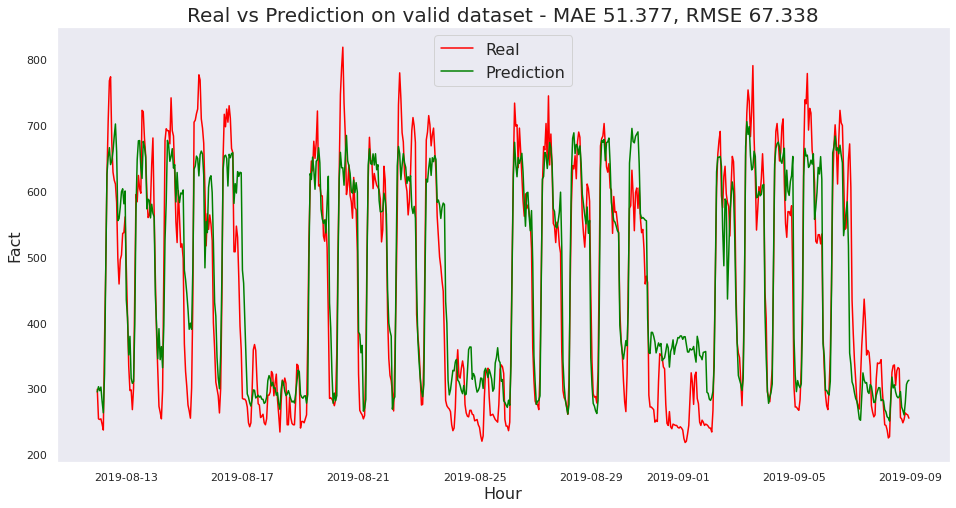

In [66]:
plot_valid(valid_preds, y_valid, mae, rmse)

Попробуем найти лучшую комбинацию параметров для модели RandomForestRegressor

In [67]:
n_estimators = [5,20,50,100]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)]
min_samples_split = [2, 6, 10]
min_samples_leaf = [1, 3, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

In [68]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
               n_iter = 100, random_state=42, n_jobs = -1)

In [70]:
rf_random.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      120],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 4],
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [5, 20, 50, 100]},
                   random_state=42)

In [71]:
#print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')

Best Parameters:  {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': True}  



In [72]:
randmf = RandomForestRegressor(n_estimators = 100, min_samples_split = 2, min_samples_leaf= 4, max_features = 'sqrt', max_depth= 70, bootstrap=True) 
randmf.fit( X_train, y_train) 

RandomForestRegressor(max_depth=70, max_features='sqrt', min_samples_leaf=4)

In [73]:
valid_preds = randmf.predict(X_valid)
submission = randmf.predict(X_test)

#calculate MAE
mae = np.round(mean_absolute_error(y_valid, valid_preds), 3)    
#calculate RMSE
rmse = np.sqrt(((y_valid - valid_preds) ** 2).mean())

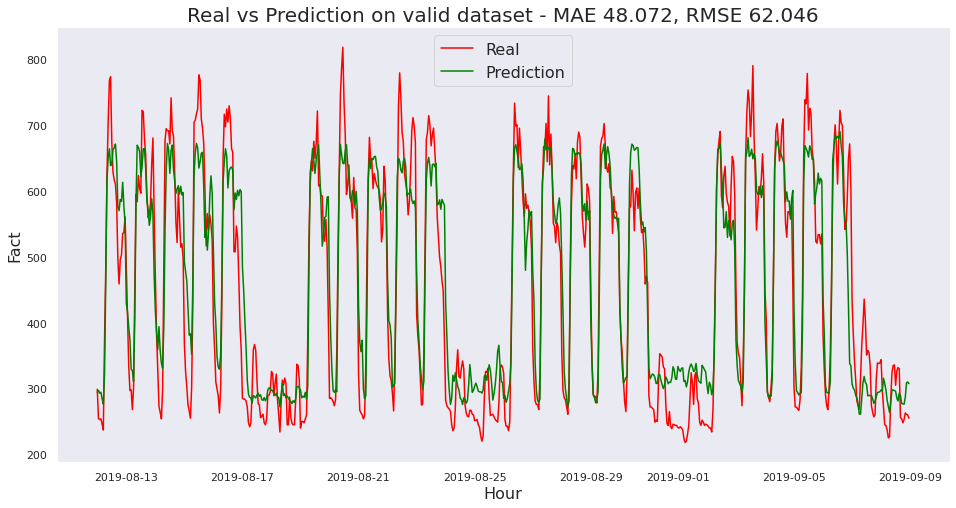

In [74]:
plot_valid(valid_preds, y_valid, mae, rmse)

#### LGBMRegressor

In [75]:
lgbm_regressor = LGBMRegressor(random_state=42)
lgbm_regressor.fit(X_train, y_train)
valid_preds = lgbm_regressor.predict(X_valid)
submission = lgbm_regressor.predict(X_test)

#calculate MAE
mae = np.round(mean_absolute_error(y_valid, valid_preds), 3)    
#calculate RMSE
rmse = np.sqrt(((y_valid - valid_preds) ** 2).mean())

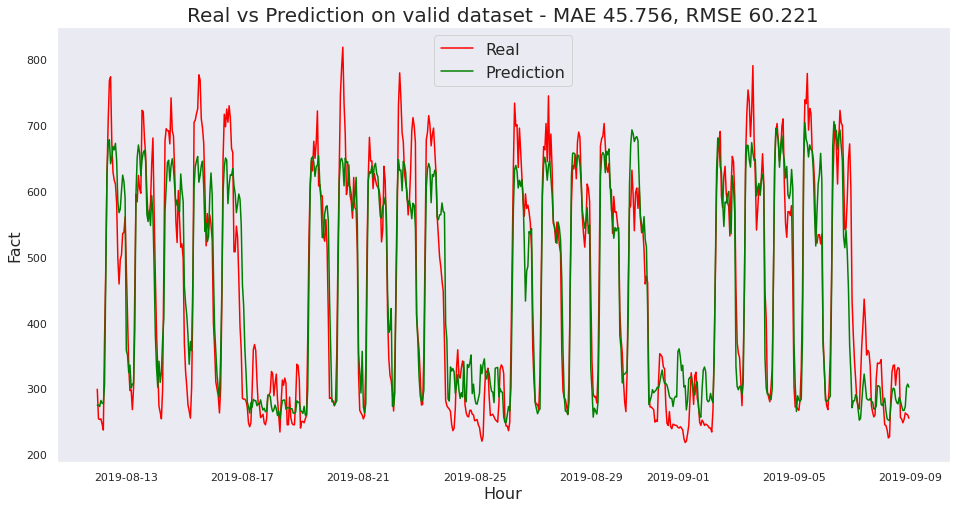

In [76]:
plot_valid(valid_preds, y_valid, mae, rmse)

#### Построим итоговый прогноз

**Лучший результат показала модель LGBTMRegressor. Построим прогноз на ее основе.**

In [81]:
predictions = lgbm_regressor.predict(X_test)

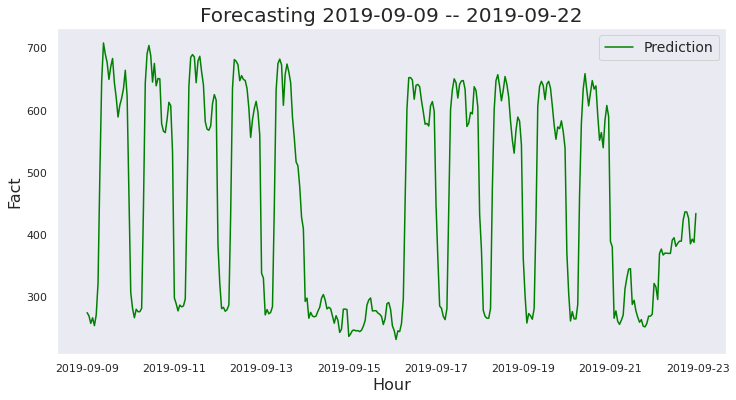

In [82]:
plot_target(predictions, X_test.index)

In [83]:
submission = pd.DataFrame({'timestamp': X_test.index, 'fact': predictions})
submission.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [84]:
submission

,timestamp,fact
0,2019-09-09 00:00:00,274.930072
1,2019-09-09 01:00:00,269.835223
2,2019-09-09 02:00:00,257.702559
3,2019-09-09 03:00:00,266.746360
4,2019-09-09 04:00:00,254.105717
...,...,...
331,2019-09-22 19:00:00,426.751101
332,2019-09-22 20:00:00,385.583945
333,2019-09-22 21:00:00,393.173735
334,2019-09-22 22:00:00,388.018872


#### Out-of-scope. Попробуем спрогнозировать отдельно trend и noise.

In [85]:
import math
from sklearn.linear_model import LinearRegression


In [86]:
y_fact = df.reset_index().drop(['timestamp'],axis=1)

#Time scale
predic1 = range(len(y_fact))

#Applying the Fourier series to the time scale
predic_week_cos = list(map(lambda x: math.cos(2*math.pi*x/168), predic1))
predic_week_sin = list(map(lambda x: math.sin(2*math.pi*x/168), predic1))

predic_day_cos = list(map(lambda x: math.cos(2*math.pi*x/24), predic1))
predic_day_sin = list(map(lambda x: math.sin(2*math.pi*x/24), predic1))

#assembling the regressors
reg = pd.DataFrame(list(zip(predic1, predic_week_cos, predic_week_sin, predic_day_cos, predic_day_sin)), 
               columns =['predic1', 'predic_week_cos', 'predic_week_sin', 'predic_day_cos', 'predic_day_sin']) 

#Model
model = LinearRegression().fit(reg, y_fact)

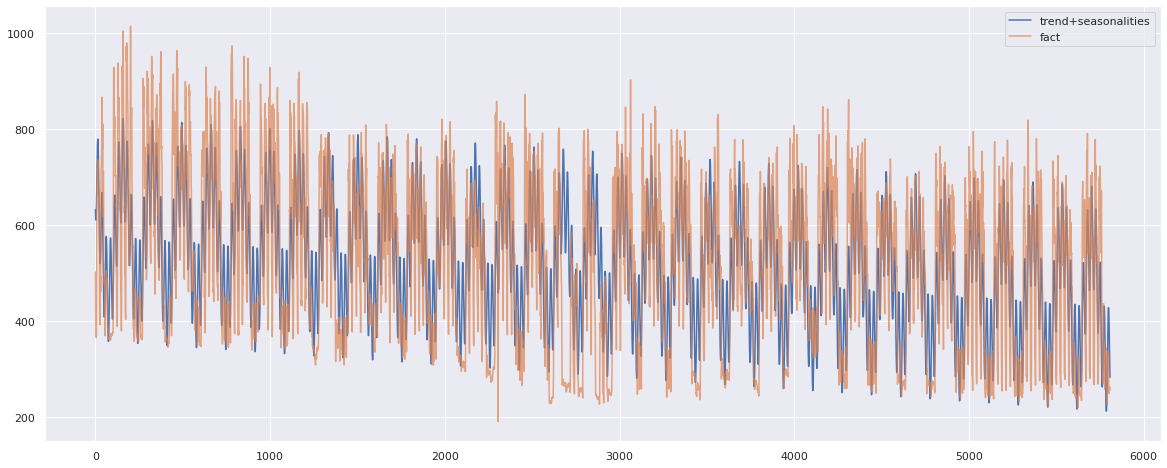

In [87]:
trend = model.intercept_ + model.coef_[0][0]*np.array(predic1)
seas_week = model.coef_[0][1] * np.array(predic_week_cos) + model.coef_[0][2] * np.array(predic_week_sin)
seas_day = model.coef_[0][3] * np.array(predic_day_cos) + model.coef_[0][4] * np.array(predic_day_sin)

trend_seas = trend + seas_week + seas_day

ax = pd.DataFrame(trend_seas, columns=['trend+seasonalities']).plot(figsize=(20,8))
y_fact.plot(ax=ax,alpha=0.7);

In [88]:
seas = seas_week + seas_day

In [89]:
df_trend = pd.DataFrame({'fact': trend}, columns=['fact'])
df_trend.index = df.index
df_trend = pd.concat([df_trend, df_forecast])

In [90]:
df_adjusted = df['fact'] - trend_seas
df_adjusted = df_adjusted.to_frame()
df_adjusted = pd.concat([df_adjusted, df_forecast])

In [91]:
def run_model(X_train, X_test, y_train, y_test, x_forecast):
    
    forest_regressor = RandomForestRegressor(n_estimators = 100, min_samples_split = 2, min_samples_leaf= 4, max_features = 'sqrt', max_depth= 70, bootstrap=True) 
    forest_regressor.fit(X_train, y_train)
    test_preds = forest_regressor.predict(X_test)
    forecast_preds = forest_regressor.predict(x_forecast)

    #calculate MAE
    mae = np.round(mean_absolute_error(y_test, test_preds), 3)    
    #calculate RMSE
    rmse = np.sqrt(((y_test - test_preds) ** 2).mean())
    print(f'MAE {mae:.{3}f}, RMSE {rmse:.{3}f}')
    
    return test_preds, forecast_preds

In [92]:
#trend
df_trend = preprocess_data(df_trend)
X_train1, X_test1, y_train1, y_test1, x_forecast= split_data(df_trend)

In [93]:
trend_pred, trend_target_preds = run_model(X_train1, X_test1, y_train1, y_test1, x_forecast)

MAE 9.352, RMSE 10.666


In [94]:
#noise
df_adjusted = preprocess_data(df_adjusted)
X_train2, X_test2, y_train2, y_test2, x_forecast = split_data(df_adjusted)

In [95]:
noise_preds, noise_target_preds = run_model(X_train2, X_test2, y_train2, y_test2, x_forecast)

MAE 49.152, RMSE 64.122


Визуализируем реальные данные и спрогнозированный результат для 4 недель до 2019-09-09

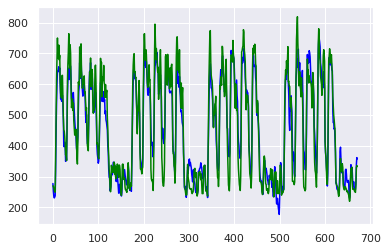

In [96]:
plt.plot(seas[-24*7*4:] + trend_pred + noise_preds, color='blue')
plt.plot(range(336*2), y_fact[-24*7*6:-24*7*2], color='green');

In [97]:
y_true = np.array(y_fact[-24*7*6:-24*7*2])
y_pred = seas[-24*7*4:] + trend_pred + noise_preds

In [100]:
#calculate MAE
mae = np.round(mean_absolute_error(y_true, y_pred), 3)    
#calculate RMSE
rmse = np.round(np.sqrt(((y_true - y_pred) ** 2).mean()), 3)

print(f'Метрики прогноза fact на 4 недели. MAE {mae:.{3}f}, RMSE {rmse:.{3}f}')

Метрики прогноза fact на 4 недели. MAE 36.564, RMSE 226.395


Визуализируем прогноз 2019-09-09 -- 2019-09-22

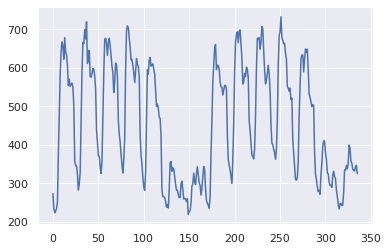

In [99]:
result = seas[-24*7*2:] + trend_target_preds + noise_target_preds
plt.plot(result);

Данным способом получилось достичь лучшего показателя по MAE, но RMSE значительно хуже, поэтому окончательный выбор пал на результат полученный случайным лесом с исходным датасетом.